# K-NN Classifier - Personal Loan Acceptance

This program is a solution to the problem 7.2 of chapter 7 of following book. 

Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python, First Edition.

Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel

© 2020 John Wiley & Sons, Inc. Published 2020 by John Wiley & Sons, Inc.

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd

import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib as mpl
import matplotlib.pyplot as plt

Printing versions of libraries

In [2]:
print('pandas version: {}'.format(pd.__version__))
print('sklearn version: {}'.format(skl.__version__))
print('matplotlib version: {}'.format(mpl.__version__))

pandas version: 1.5.3
sklearn version: 1.2.1
matplotlib version: 3.7.0


## Loading Dataset

In [3]:
df = pd.read_csv('UniversalBank.csv')

In [4]:
# Renaming columns to remove space in column names
df = df.rename(columns={'ZIP Code': 'ZIP_Code', 
                        'Personal Loan': 'Personal_Loan', 
                        'Securities Account': 'Securities_Account', 
                        'CD Account':'CD_Account'})

# Dropping columns ID and ZIP Code because they are not needed for our k-nn classification.
df = df.drop(['ID', 'ZIP_Code'], axis=1)
display(df.head())

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,25,1,49,4,1.6,1,0,0,1,0,0,0
1,45,19,34,3,1.5,1,0,0,1,0,0,0
2,39,15,11,1,1.0,1,0,0,0,0,0,0
3,35,9,100,1,2.7,2,0,0,0,0,0,0
4,35,8,45,4,1.0,2,0,0,0,0,0,1


In [5]:
display(df.head())

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,25,1,49,4,1.6,1,0,0,1,0,0,0
1,45,19,34,3,1.5,1,0,0,1,0,0,0
2,39,15,11,1,1.0,1,0,0,0,0,0,0
3,35,9,100,1,2.7,2,0,0,0,0,0,0
4,35,8,45,4,1.0,2,0,0,0,0,0,1


Transforming categorical predictors with more than two categories into dummy variables first

In [6]:
# Create dummy variables from the Education column
df = pd.get_dummies(df, columns=['Education'])
display(df.head())

,Age,Experience,Income,Family,CCAvg,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,Education_1,Education_2,Education_3
0,25,1,49,4,1.6,0,0,1,0,0,0,1,0,0
1,45,19,34,3,1.5,0,0,1,0,0,0,1,0,0
2,39,15,11,1,1.0,0,0,0,0,0,0,1,0,0
3,35,9,100,1,2.7,0,0,0,0,0,0,0,1,0
4,35,8,45,4,1.0,0,0,0,0,0,1,0,1,0


Making Personal_Loan as a last column of the dataframe.

In [7]:
column_to_move = df.pop('Personal_Loan')
df.insert((len(list(df))), 'Personal_Loan', column_to_move)
display(df.head())

,Age,Experience,Income,Family,CCAvg,Mortgage,Securities_Account,CD_Account,Online,CreditCard,Education_1,Education_2,Education_3,Personal_Loan
0,25,1,49,4,1.6,0,1,0,0,0,1,0,0,0
1,45,19,34,3,1.5,0,1,0,0,0,1,0,0,0
2,39,15,11,1,1.0,0,0,0,0,0,1,0,0,0
3,35,9,100,1,2.7,0,0,0,0,0,0,1,0,0
4,35,8,45,4,1.0,0,0,0,0,1,0,1,0,0


Partitioning the data into training (60%) and validation (40%) sets.

In [8]:
trainData, validData = train_test_split(df, 
                                        test_size=0.4, 
                                        random_state=26)

Creating dataset for prospect customer

In [9]:
prospect = pd.DataFrame([{'Age': 40, 
                          'Experience': 10, 
                          'Income': 84, 
                          'Family': 2, 
                          'CCAvg': 2, 
                          'Mortgage': 0, 
                          'Securities_Account': 0, 
                          'CD_Account': 0, 
                          'Online': 1, 
                          'CreditCard': 1, 
                          'Education_1': 0, 
                          'Education_2': 1, 
                          'Education_3': 0}])
display(prospect)

,Age,Experience,Income,Family,CCAvg,Mortgage,Securities_Account,CD_Account,Online,CreditCard,Education_1,Education_2,Education_3
0,40,10,84,2,2,0,0,0,1,1,0,1,0


## Normalizing Dataset

In [10]:
# initialize normalized training, validation, and complete data frames
# use the training data to learn the transformation.
scaler = preprocessing.StandardScaler()
scaler.fit(trainData.iloc[:, :-1]) 

# Transform the full dataaset 
dfNorm = pd.concat([pd.DataFrame(
    scaler.transform(df.iloc[:, :-1]), 
    columns= df.columns.tolist()[:-1]),
                       df[['Personal_Loan']]], axis=1)

display(dfNorm.head())

trainNorm = dfNorm.iloc[trainData.index]
validNorm = dfNorm.iloc[validData.index]

prospectNorm = pd.DataFrame(scaler.transform(prospect),
                                columns=prospect.columns)
display(prospectNorm)

,Age,Experience,Income,Family,CCAvg,Mortgage,Securities_Account,CD_Account,Online,CreditCard,Education_1,Education_2,Education_3,Personal_Loan
0,-1.761111,-1.655564,-0.525899,1.400063,-0.179980,-0.547625,2.888909,-0.248891,-1.24019,-0.645314,1.167135,-0.629800,-0.643242,0
1,-0.025599,-0.092619,-0.855538,0.529738,-0.237394,-0.547625,2.888909,-0.248891,-1.24019,-0.645314,1.167135,-0.629800,-0.643242,0
2,-0.546253,-0.439940,-1.360985,-1.210912,-0.524464,-0.547625,-0.346151,-0.248891,-1.24019,-0.645314,1.167135,-0.629800,-0.643242,0
3,-0.893355,-0.960922,0.594874,-1.210912,0.451575,-0.547625,-0.346151,-0.248891,-1.24019,-0.645314,-0.856799,1.587806,-0.643242,0
4,-0.893355,-1.047752,-0.613803,1.400063,-0.524464,-0.547625,-0.346151,-0.248891,-1.24019,1.549632,-0.856799,1.587806,-0.643242,0


,Age,Experience,Income,Family,CCAvg,Mortgage,Securities_Account,CD_Account,Online,CreditCard,Education_1,Education_2,Education_3
0,-0.459477,-0.874091,0.243259,-0.340587,0.049677,-0.547625,-0.346151,-0.248891,0.806328,1.549632,-0.856799,1.587806,-0.643242


## K-NN Classification (K = 1)

Performing a k-NN classification with all predictors except ID and ZIP code using k = 1.

In [11]:
# use NearestNeighbors from scikit-learn to compute knn
knn = NearestNeighbors(n_neighbors=1)
knn.fit(dfNorm.iloc[:, :-1])
distances, indices = knn.kneighbors(prospectNorm)

# indices is a list of lists, we are only interested in the first element
dfNorm.iloc[indices[0], :]

,Age,Experience,Income,Family,CCAvg,Mortgage,Securities_Account,CD_Account,Online,CreditCard,Education_1,Education_2,Education_3,Personal_Loan
4034,-0.893355,-0.787261,0.199307,-0.340587,-0.122566,-0.547625,-0.346151,-0.248891,0.806328,1.549632,-0.856799,1.587806,-0.643242,0


## Result

From above grid we see that closest neighbors to our prospect customer is a customer who did not accept the loan. Therefore, our prospect customer is also not likely to accept the loan. Since we are using only one neighbor, the cutoff value of 0.5 is not applicable here. However, as we will see further, the cutoff value will be applicable when we try classification with more than one neighbor.

## Finding best value of k 

Finding choice of k that balances between overfitting and ignoring the predictor information. Trying out k = 1 to k = 15. 

In [12]:
train_X = trainNorm.drop('Personal_Loan', axis=1)
train_y = trainNorm['Personal_Loan']
valid_X = validNorm.drop('Personal_Loan', axis=1)
valid_y = validNorm['Personal_Loan']

# Train a classifier for different values of k
results = []
for k in range(1, 16):
    knn = KNeighborsClassifier(n_neighbors=k).fit(train_X, train_y)
    results.append({
        'k': k,
        'accuracy': accuracy_score(valid_y, knn.predict(valid_X))
    })
    
# Convert results to a pandas data frame
results = pd.DataFrame(results)
print(results)

     k  accuracy
0    1    0.9550
1    2    0.9460
2    3    0.9555
3    4    0.9445
4    5    0.9525
5    6    0.9445
6    7    0.9495
7    8    0.9425
8    9    0.9460
9   10    0.9430
10  11    0.9450
11  12    0.9390
12  13    0.9405
13  14    0.9350
14  15    0.9380


## Result

From above table we see that accuracy is best when k = 3. Therefore, when we use k = 3, we will get the best classification performance. Choice of k = 3 will balance between overfitting and ignoring the predictor information. If we choose value of k that is less than 3, then we will classify in a way that is very sensitive to the local characteristics of the training data. Likewise, if we choose a very large value of k, such as k = 15, we sould simply predict the most frequent class in the dataset in all cases. K = 15 would be very stable prediction but it will completely ignore the information in the predictors.

## Confusion Matrix

Displaying the confusion matrix for the validation data that results from using the best k. In our case, it is k = 3.

In [17]:
knn = KNeighborsClassifier(n_neighbors=3).fit(train_X, train_y)
predicted = knn.predict(valid_X)

cm = confusion_matrix(valid_y, predicted)
print('Confusion Matrix')
print(cm)

Confusion Matrix
[[1779    6]
 [  83  132]]


Finding counts of Actual and Predicted values so that we can label axes correctly during plotting confusion matrix.

In [20]:
print('Actual Value Counts')
print('Type: ', type(valid_y)) # We need to find the type so that we can call relevant methods on the object to find the required counts below
print('Total Element Count: {}'.format(len(valid_y)))
print('Not Accept Count: {}'.format(len(valid_y.loc[valid_y == 0])))
print('Accept Count: {}'.format(len(valid_y.loc[valid_y == 1])))

print('\nPredicted Value Counts')
print('Type: ', type(predicted)) # We need to find the type so that we can call relevant methods on the object to find the required counts below
print('Total Element Count: {}'.format(len(predicted)))
print('Not Accept Count: {}'.format(len(predicted[predicted == 0])))
print('Accept Count: {}'.format(len(predicted[predicted == 1])))

Actual Value Counts
Type:  <class 'pandas.core.series.Series'>
Total Element Count: 2000
Not Accept Count: 1785
Accept Count: 215

Predicted Value Counts
Type:  <class 'numpy.ndarray'>
Total Element Count: 2000
Not Accept Count: 1862
Accept Count: 138


Combining information from above confusion matrix and value counts we can conclude following about labels of axes in plot of confusion matrix. 

1. Sum of values in top row of confusion matrix above (1779 + 6) = 1785, which is Not Accept Count of Actual values as calculated above. Therefore, in the plot below, on the y-axis, where we display Acutal counts, the label of top row will be 'Not Accept'. If the label of top row is 'Not Accept' then label of bottom row will be 'Accept'.

2. Likewise, Sum values in the first column of confusion matrix above (1779 + 83) = 1862, which is Not Accept Count of Predicted values as calculated above. Therefore, the plot below, on the x-axis, where we display Predicted counts, the label of first column will be 'Not Accept'. If the label of first column is 'Not Accept', then the label of second column will be 'Accept'.

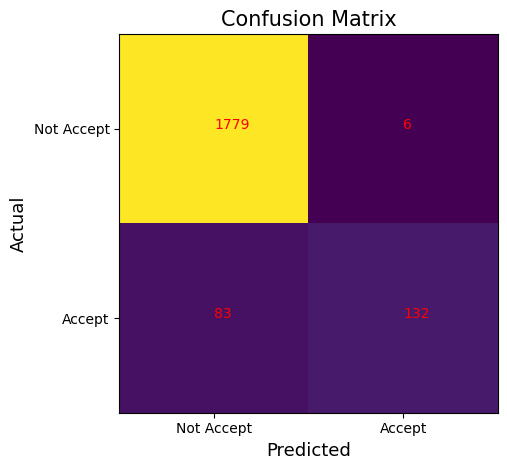

In [16]:
fig, ax = plt.subplots()
im = ax.imshow(cm)

# Showing all ticks and labelling them with the respective list entries
ax.set_xticks(np.arange(2), labels=['Not Accept', 'Accept'])
ax.set_yticks(np.arange(2), labels=['Not Accept', 'Accept'])

# Setting labels for x-axis and y-axis
ax.set_xlabel('Predicted', fontsize=13)
ax.set_ylabel('Actual', fontsize=13)

# Creating text annotations.
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, cm[i, j], color='r')

ax.set_title('Confusion Matrix', fontsize=15)
fig.tight_layout()
plt.show()